# Graph Neural Network-Based Community Detection

This notebook demonstrates how to use Graph Neural Networks (GNNs) for community detection. We'll explore:

1. Loading and preparing graphs for GNN processing
2. Implementing and training different GNN architectures
3. Extracting node embeddings and performing clustering
4. Evaluating detection results against ground truth
5. Comparing different GNN models

In [1]:
import sys
import os
import numpy as np
import torch
import polars as pl
import rustworkx as rx
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import warnings
warnings.filterwarnings('ignore')

# Import directly from the community_detection package
from community_detection.gnn_community_detection import (
    rwx_to_pyg, GCN, GraphSAGE, GAT, VGAE,
    train_gnn_embedding, extract_embeddings, detect_communities_from_embeddings,
    evaluate_communities, plot_embeddings, add_communities_to_graph,
    run_gnn_community_detection, compare_gnn_models
)

# Import functions from data_prep for generating graphs if needed
from community_detection.data_prep import generate_synthetic_graph

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool'}


2025-03-31 16:02:52.441241: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743451372.512117  622943 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743451372.531257  622943 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743451372.682895  622943 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743451372.682937  622943 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743451372.682938  622943 computation_placer.cc:177] computation placer alr

## 1. Check PyTorch Geometric Availability

GNN-based methods require PyTorch and PyTorch Geometric. Let's check if they're available.

In [2]:
# Check if PyTorch Geometric is available
try:
    import torch_geometric
    from torch_geometric.data import Data
    TORCH_GEOMETRIC_AVAILABLE = True
    print("PyTorch Geometric is available.")
except ImportError:
    TORCH_GEOMETRIC_AVAILABLE = False
    print("PyTorch Geometric is not available. Please install it to run GNN-based methods.")
    print("You can install it with: pip install torch-geometric")

PyTorch Geometric is available.


## 2. Load or Generate Test Graph

Let's load the graph we've been using in previous notebooks.

Loading SBM graph from file...


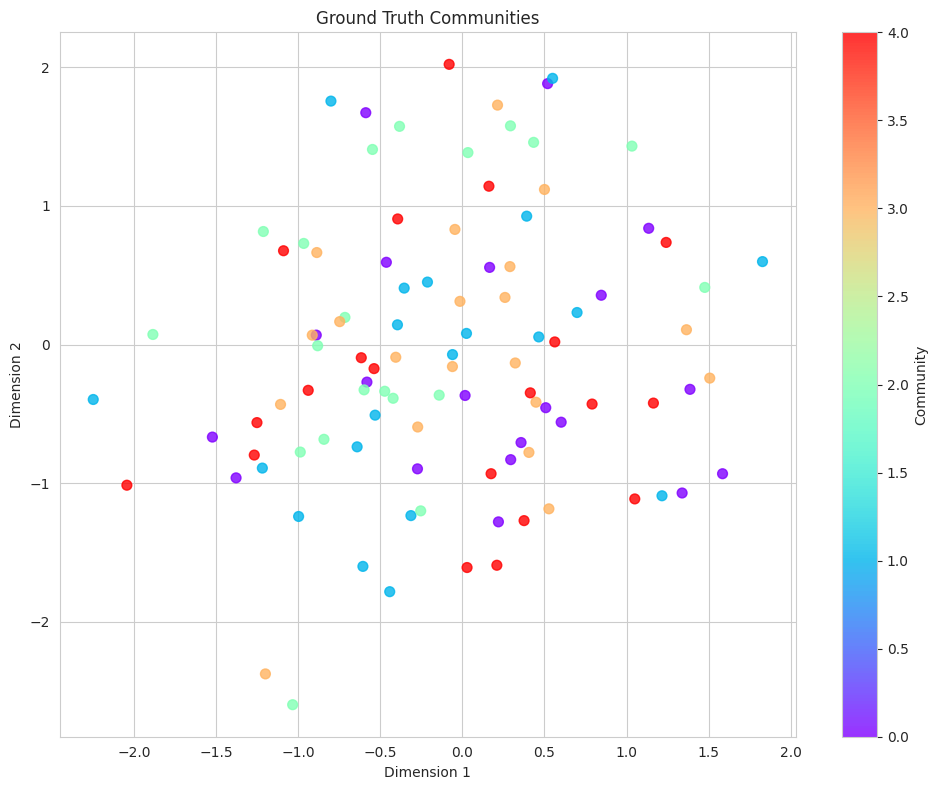

In [3]:
# Check if PyTorch Geometric is available before proceeding
if not TORCH_GEOMETRIC_AVAILABLE:
    print("PyTorch Geometric is required for this notebook. Please install it and restart the notebook.")
else:
    # Check if previously saved graphs are available
    if os.path.exists('data/sbm_graph.gpickle'):
        # Load the SBM graph using pickle
        print("Loading SBM graph from file...")
        with open('data/sbm_graph.gpickle', 'rb') as f:
            G = pickle.load(f)
    else:
        # Generate a new SBM graph
        print("Generating a new SBM graph...")
        n_communities = 5
        G, _ = generate_synthetic_graph(
            'sbm', 
            n_nodes=100, 
            n_communities=n_communities,
            p_in=0.3, 
            p_out=0.05
        )
        
        # Save the graph in pickle format for future use
        os.makedirs('data', exist_ok=True)
        with open('data/sbm_graph.gpickle', 'wb') as f:
            pickle.dump(G, f)
        print("Generated and saved new SBM graph.")

    # Extract ground truth communities
    ground_truth = {}
    for i in range(len(G)):
        node_data = G.get_node_data(i)
        if node_data and 'community' in node_data:
            ground_truth[i] = node_data['community']

    # Visualize the graph with ground truth communities
    plot_embeddings(torch.randn(len(G), 2), torch.tensor([ground_truth.get(i, 0) for i in range(len(G))]), 
                  method='none', title="Ground Truth Communities")

## 3. GCN-Based Community Detection

Let's start with a Graph Convolutional Network (GCN) model.

Running GCN-based community detection...
Training GCN model...
Epoch 10/100, Loss: 2.2624
Epoch 20/100, Loss: 1.7015
Epoch 30/100, Loss: 1.5787
Epoch 40/100, Loss: 1.4805
Epoch 50/100, Loss: 1.4821
Epoch 60/100, Loss: 1.3122
Epoch 70/100, Loss: 1.1772
Epoch 80/100, Loss: 1.0455
Epoch 90/100, Loss: 0.9215
0/100, Loss: 0.8622Epoch 20/100, Loss: 1.7015
Epoch 30/100, Loss: 1.5787
Epoch 40/100, Loss: 1.4805
Epoch 50/100, Loss: 1.4821
Epoch 60/100, Loss: 1.3122
Epoch 70/100, Loss: 1.1772
Epoch 80/100, Loss: 1.0455
Epoch 90/100, Loss: 0.9215

Training completed in 0.79 seconds
Extracting node embeddings...
Detecting communities with KMeans (n_clusters=5)...
Visualizing node embeddings...


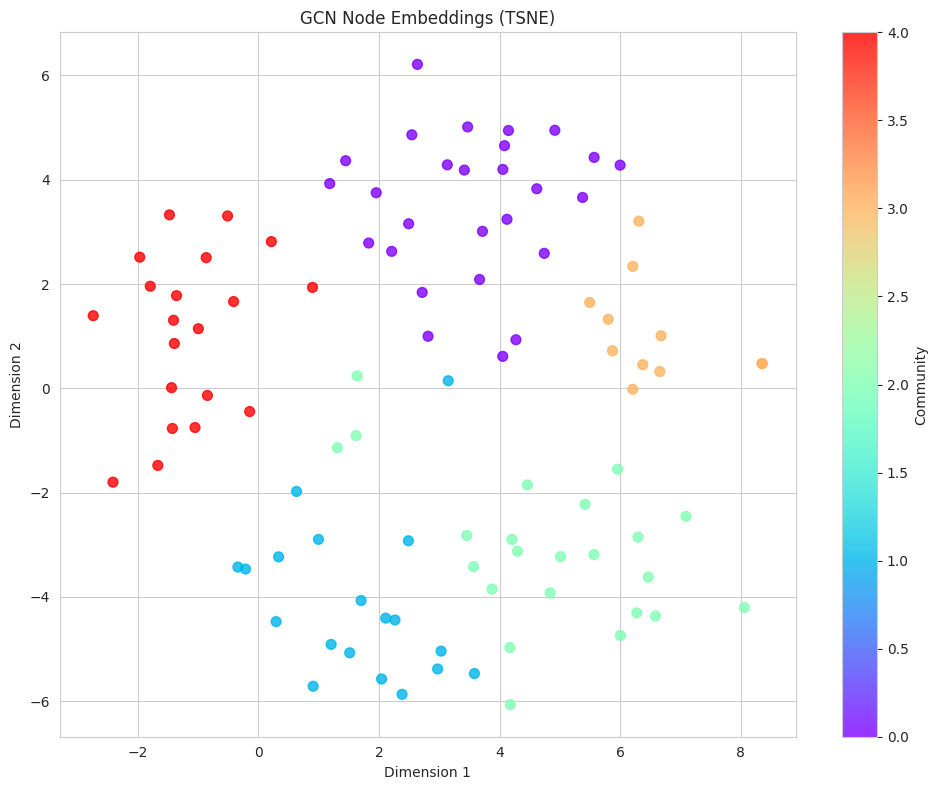


Evaluation against ground truth:
NMI: 0.4116
ARI: 0.2917


In [4]:
if TORCH_GEOMETRIC_AVAILABLE:
    # Run GCN-based community detection
    print("Running GCN-based community detection...")
    
    # Get number of communities from ground truth
    n_clusters = len(set(ground_truth.values()))
    
    # Run GCN
    gcn_results = run_gnn_community_detection(
        G, 
        model_type='gcn',
        embedding_dim=16,
        n_clusters=n_clusters,
        epochs=100,
        ground_truth_attr='community'
    )
    
    # Save results
    os.makedirs('results', exist_ok=True)
    with open('results/gcn_results.pkl', 'wb') as f:
        pickle.dump(gcn_results, f)

## 4. GraphSAGE-Based Community Detection

Now let's try GraphSAGE, which is particularly good for inductive learning tasks.

Running GraphSAGE-based community detection...
Training GRAPHSAGE model...
Epoch 10/100, Loss: 1.8433
Epoch 20/100, Loss: 1.5462
Epoch 30/100, Loss: 1.3233
Epoch 40/100, Loss: 1.3068
Epoch 50/100, Loss: 1.0483
Epoch 60/100, Loss: 0.9204
Epoch 70/100, Loss: 0.7731
Epoch 80/100, Loss: 0.7539
Epoch 90/100, Loss: 0.6146
100/100, Loss: 0.6068
Training completed in 0.19 seconds
Extracting node embeddings...
Detecting communities with KMeans (n_clusters=5)...
Visualizing node embeddings...


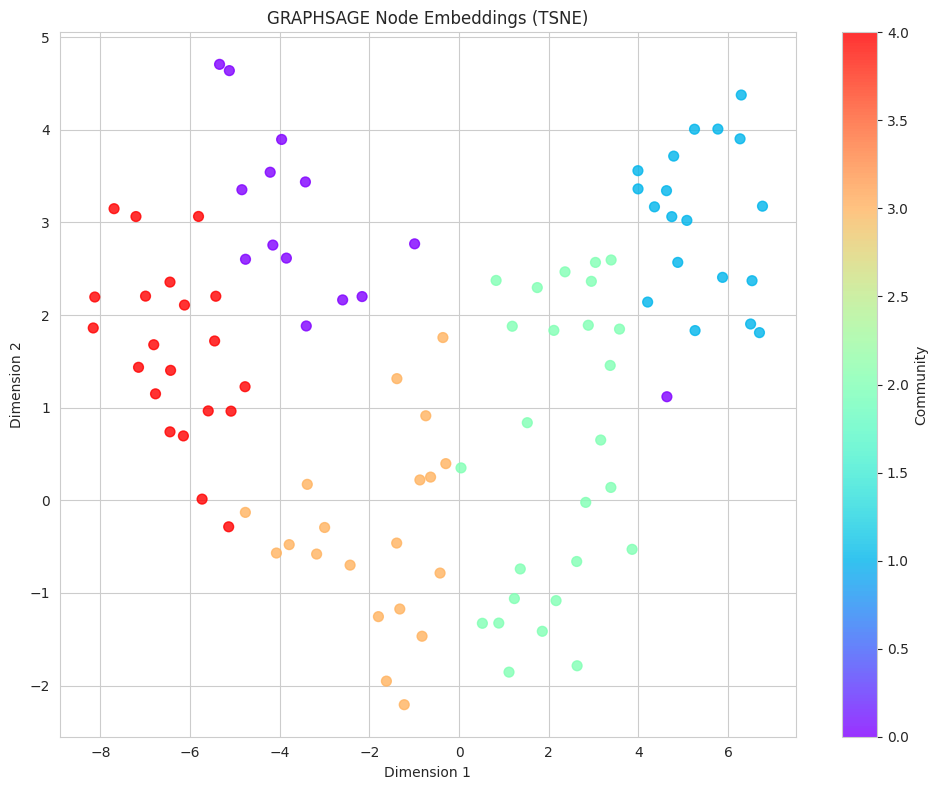


Evaluation against ground truth:
NMI: 0.4750
ARI: 0.3768


In [5]:
if TORCH_GEOMETRIC_AVAILABLE:
    # Run GraphSAGE-based community detection
    print("Running GraphSAGE-based community detection...")
    
    # Run GraphSAGE
    graphsage_results = run_gnn_community_detection(
        G, 
        model_type='graphsage',
        embedding_dim=16,
        n_clusters=n_clusters,
        epochs=100,
        ground_truth_attr='community'
    )
    
    # Save results
    with open('results/graphsage_results.pkl', 'wb') as f:
        pickle.dump(graphsage_results, f)

## 5. GAT-Based Community Detection

Graph Attention Networks (GAT) use attention mechanisms to weight neighbor nodes' influence.

Running GAT-based community detection...
Training GAT model...
Epoch 10/100, Loss: 1.5915
Epoch 20/100, Loss: 1.3852
Epoch 30/100, Loss: 1.2016
40/100, Loss: 0.9107

Epoch 50/100, Loss: 0.7523
Epoch 60/100, Loss: 0.7305
Epoch 70/100, Loss: 0.4982
Epoch 80/100, Loss: 0.3559h 50/100, Loss: 0.7523
Epoch 60/100, Loss: 0.7305
Epoch 70/100, Loss: 0.4982

90/100, Loss: 0.2797h 50/100, Loss: 0.7523
Epoch 60/100, Loss: 0.7305
Epoch 70/100, Loss: 0.4982


Epoch 100/100, Loss: 0.2048
Training completed in 0.46 seconds
Extracting node embeddings...
Detecting communities with KMeans (n_clusters=5)...
Visualizing node embeddings...


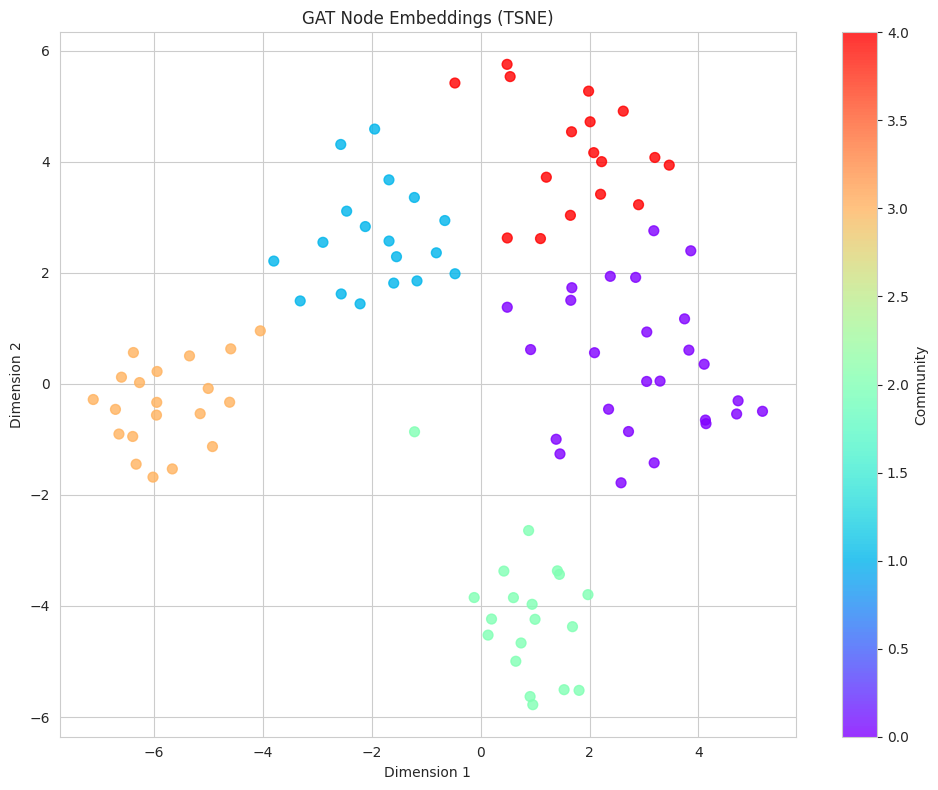


Evaluation against ground truth:
NMI: 0.8212
ARI: 0.7891


In [6]:
if TORCH_GEOMETRIC_AVAILABLE:
    # Run GAT-based community detection
    print("Running GAT-based community detection...")
    
    # Run GAT
    gat_results = run_gnn_community_detection(
        G, 
        model_type='gat',
        embedding_dim=16,
        n_clusters=n_clusters,
        epochs=100,
        ground_truth_attr='community'
    )
    
    # Save results
    with open('results/gat_results.pkl', 'wb') as f:
        pickle.dump(gat_results, f)

## 6. VGAE-Based Community Detection

Variational Graph Autoencoders (VGAE) learn latent representations in an unsupervised manner.

Running VGAE-based community detection...
Training VGAE model...
Epoch 10/100, Loss: 1.2230
Epoch 20/100, Loss: 0.8742
30/100, Loss: 0.8643

Epoch 40/100, Loss: 0.8483
Epoch 50/100, Loss: 0.8334h 40/100, Loss: 0.8483

60/100, Loss: 0.8465h 40/100, Loss: 0.8483


Epoch 70/100, Loss: 0.8510
Epoch 80/100, Loss: 0.850900, Loss: 0.8483


Epoch 70/100, Loss: 0.8510

90/100, Loss: 0.846800, Loss: 0.8483


Epoch 70/100, Loss: 0.8510


Epoch 100/100, Loss: 0.8329
Training completed in 0.76 seconds
Extracting node embeddings...
Detecting communities with KMeans (n_clusters=5)...
Visualizing node embeddings...


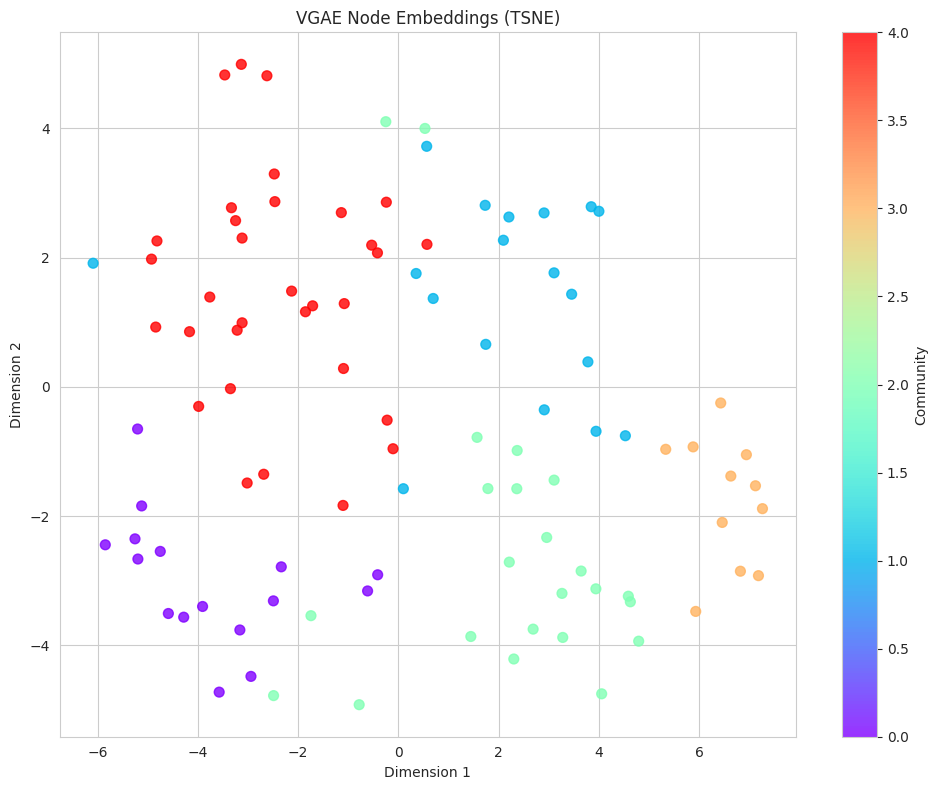


Evaluation against ground truth:
NMI: 0.3576
ARI: 0.2322


In [7]:
if TORCH_GEOMETRIC_AVAILABLE:
    # Run VGAE-based community detection
    print("Running VGAE-based community detection...")
    
    # Run VGAE
    vgae_results = run_gnn_community_detection(
        G, 
        model_type='vgae',
        embedding_dim=16,
        n_clusters=n_clusters,
        epochs=100,
        ground_truth_attr='community'
    )
    
    # Save results
    with open('results/vgae_results.pkl', 'wb') as f:
        pickle.dump(vgae_results, f)

## 7. Comparing GNN Models

Now, let's run a comprehensive comparison of all the GNN-based methods.

Comparing different GNN models...

Running GCN
Training GCN model...
Epoch 10/100, Loss: 2.3147
Epoch 20/100, Loss: 1.7156
Epoch 30/100, Loss: 1.6106
Epoch 40/100, Loss: 1.5410
Epoch 50/100, Loss: 1.4592
Epoch 60/100, Loss: 1.5116
Epoch 70/100, Loss: 1.3103
Epoch 80/100, Loss: 1.3096
Epoch 90/100, Loss: 1.1459
Epoch 100/100, Loss: 0.9824
Training completed in 0.39 seconds
Extracting node embeddings...
Detecting communities with KMeans (n_clusters=5)...
Visualizing node embeddings...


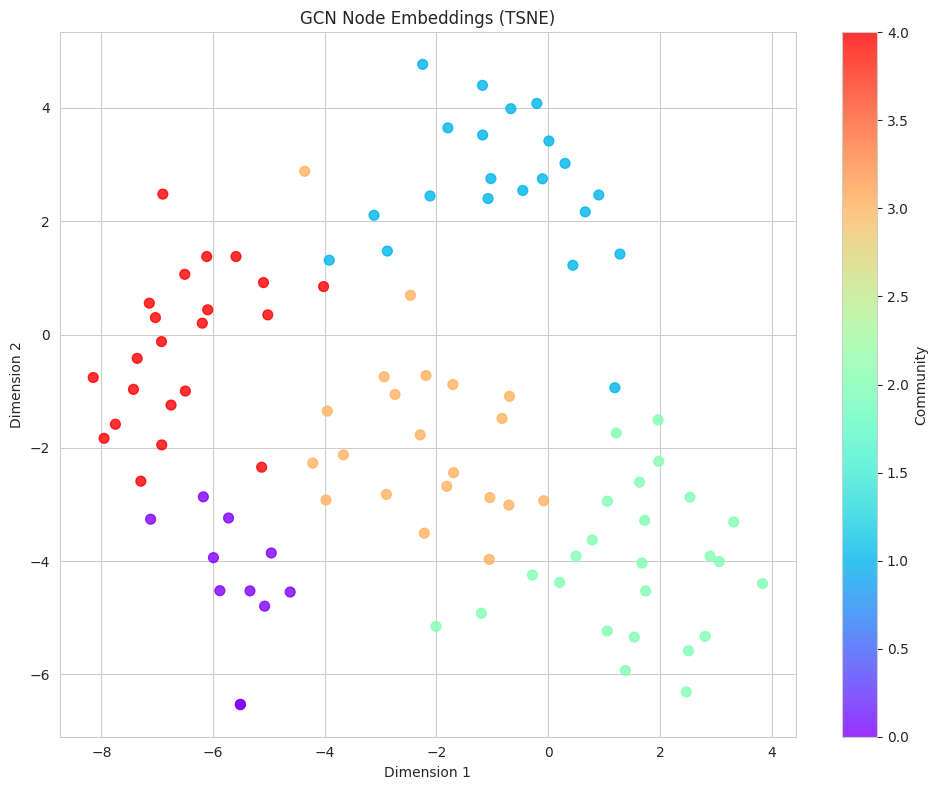


Evaluation against ground truth:
NMI: 0.3395
ARI: 0.2012

Running GRAPHSAGE
Training GRAPHSAGE model...
Epoch 10/100, Loss: 1.8458
Epoch 20/100, Loss: 1.5412
Epoch 30/100, Loss: 1.2674
Epoch 40/100, Loss: 1.2512
Epoch 50/100, Loss: 1.0621
Epoch 60/100, Loss: 0.9037
Epoch 70/100, Loss: 0.7613
Epoch 80/100, Loss: 0.5931
Epoch 90/100, Loss: 0.5935
Epoch 100/100, Loss: 0.5586
Training completed in 0.24 seconds
Extracting node embeddings...
Detecting communities with KMeans (n_clusters=5)...
Visualizing node embeddings...


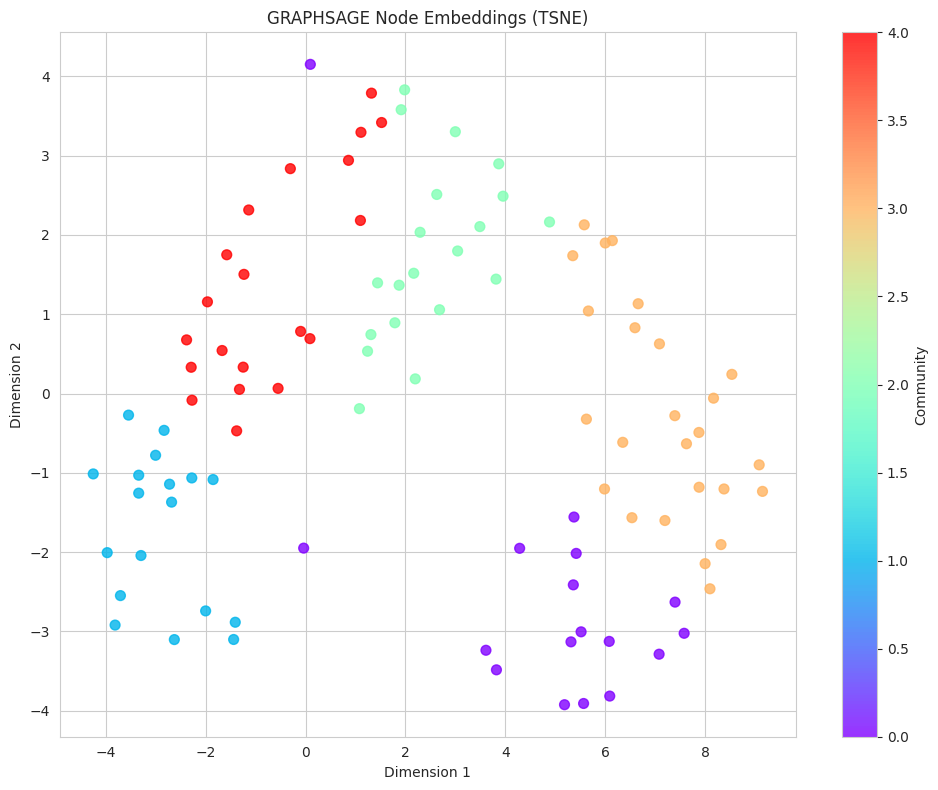


Evaluation against ground truth:
NMI: 0.5197
ARI: 0.4215

Running GAT
Training GAT model...
Epoch 10/100, Loss: 1.6010
Epoch 20/100, Loss: 1.3632
Epoch 30/100, Loss: 1.1257
Epoch 40/100, Loss: 0.8079
Epoch 50/100, Loss: 0.5280
Epoch 60/100, Loss: 0.4160
70/100, Loss: 0.3361
Epoch 50/100, Loss: 0.5280
Epoch 60/100, Loss: 0.4160

Epoch 80/100, Loss: 0.2403
Epoch 90/100, Loss: 0.2302
Epoch 100/100, Loss: 0.1588
Training completed in 0.65 seconds
Extracting node embeddings...
Detecting communities with KMeans (n_clusters=5)...
Visualizing node embeddings...100, Loss: 0.5280
Epoch 60/100, Loss: 0.4160

Epoch 80/100, Loss: 0.2403
Epoch 90/100, Loss: 0.2302
Epoch 100/100, Loss: 0.1588
Training completed in 0.65 seconds
Extracting node embeddings...
Detecting communities with KMeans (n_clusters=5)...



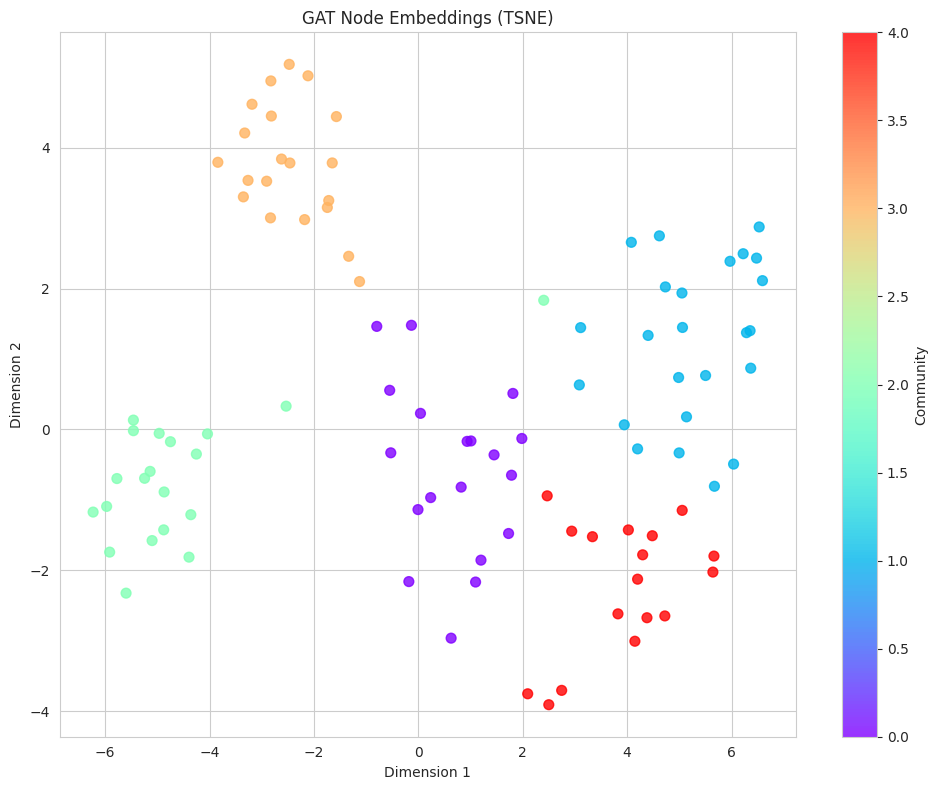


Evaluation against ground truth:
NMI: 0.8719
ARI: 0.8426

Running VGAE
Training VGAE model...
Epoch 10/100, Loss: 1.3124
Epoch 20/100, Loss: 0.8738
Epoch 30/100, Loss: 0.8664
Epoch 40/100, Loss: 0.8493
Epoch 50/100, Loss: 0.8348
Epoch 60/100, Loss: 0.8529
Epoch 70/100, Loss: 0.8416
80/100, Loss: 0.8499
Epoch 50/100, Loss: 0.8348
Epoch 60/100, Loss: 0.8529
Epoch 70/100, Loss: 0.8416

Epoch 90/100, Loss: 0.8360
Epoch 100/100, Loss: 0.8406
Training completed in 0.61 seconds
Extracting node embeddings...
Detecting communities with KMeans (n_clusters=5)...
Visualizing node embeddings...


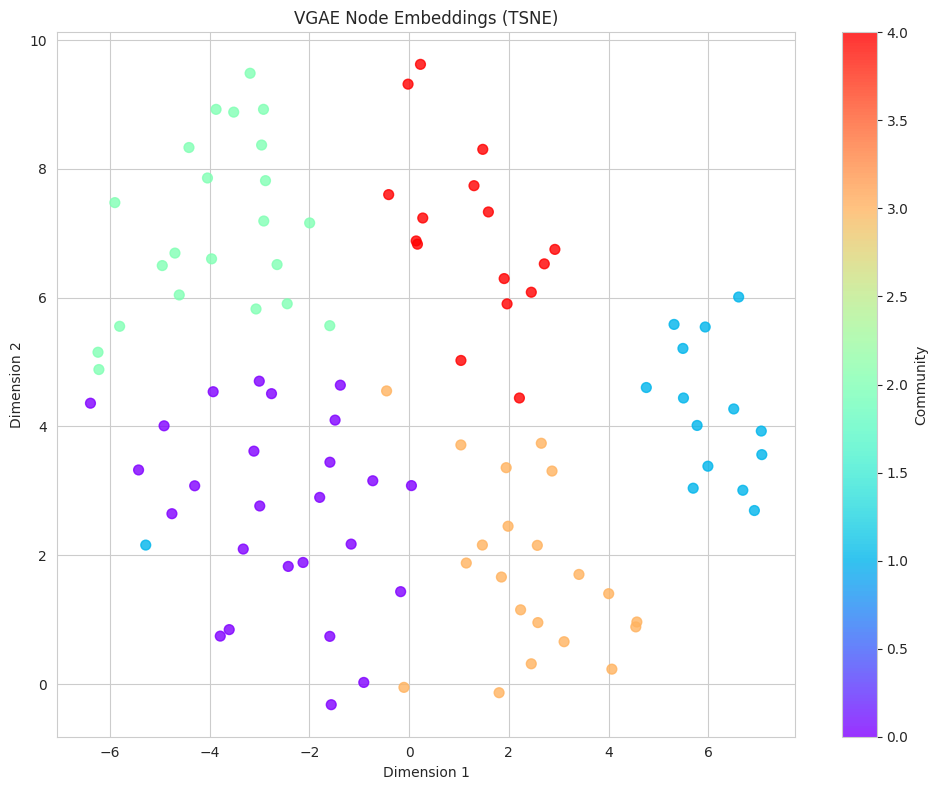


Evaluation against ground truth:
NMI: 0.1942
ARI: 0.1138


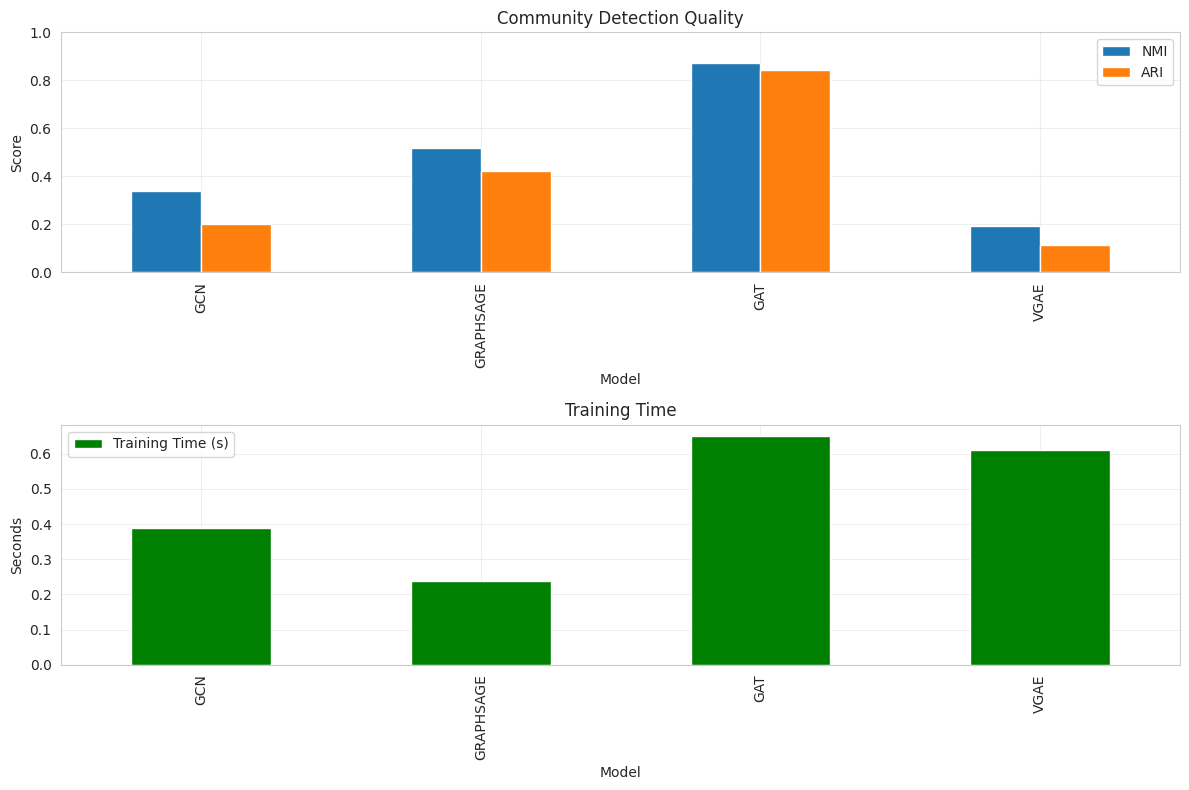


Comparison Results:
shape: (4, 5)
┌───────────┬───────────────────┬─────────────────┬──────────┬──────────┐
│ Model     ┆ Training Time (s) ┆ Num Communities ┆ NMI      ┆ ARI      │
│ ---       ┆ ---               ┆ ---             ┆ ---      ┆ ---      │
│ str       ┆ f64               ┆ i64             ┆ f64      ┆ f64      │
╞═══════════╪═══════════════════╪═════════════════╪══════════╪══════════╡
│ GCN       ┆ 0.389189          ┆ 5               ┆ 0.339502 ┆ 0.201202 │
│ GRAPHSAGE ┆ 0.239395          ┆ 5               ┆ 0.519713 ┆ 0.421484 │
│ GAT       ┆ 0.649287          ┆ 5               ┆ 0.87194  ┆ 0.842552 │
│ VGAE      ┆ 0.61132           ┆ 5               ┆ 0.194239 ┆ 0.113812 │
└───────────┴───────────────────┴─────────────────┴──────────┴──────────┘


In [8]:
if TORCH_GEOMETRIC_AVAILABLE:
    # Compare different GNN models
    print("Comparing different GNN models...")
    
    # Run comparison
    results_df = compare_gnn_models(
        G,
        embedding_dim=16,
        n_clusters=n_clusters,
        epochs=100,
        ground_truth_attr='community'
    )
    
    # Save the comparison results
    results_df.write_parquet('results/gnn_methods_comparison.parquet', compression="zstd")
    
    # Display results
    print("\nComparison Results:")
    print(results_df)

## 8. Visualizing Node Embeddings

Let's take a closer look at the node embeddings generated by different GNN models.


Visualizing embeddings for GCN...
Epoch 10/50, Loss: 2.2655
Epoch 20/50, Loss: 1.6772
Epoch 30/50, Loss: 1.5853
Epoch 40/50, Loss: 1.4979
Epoch 50/50, Loss: 1.4733


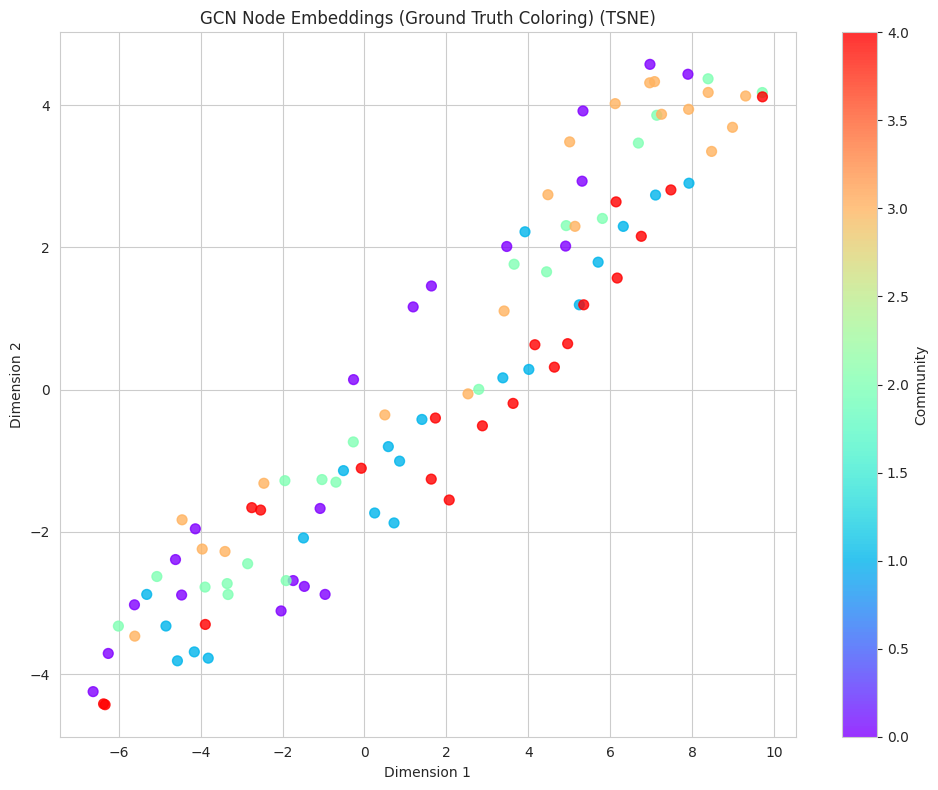

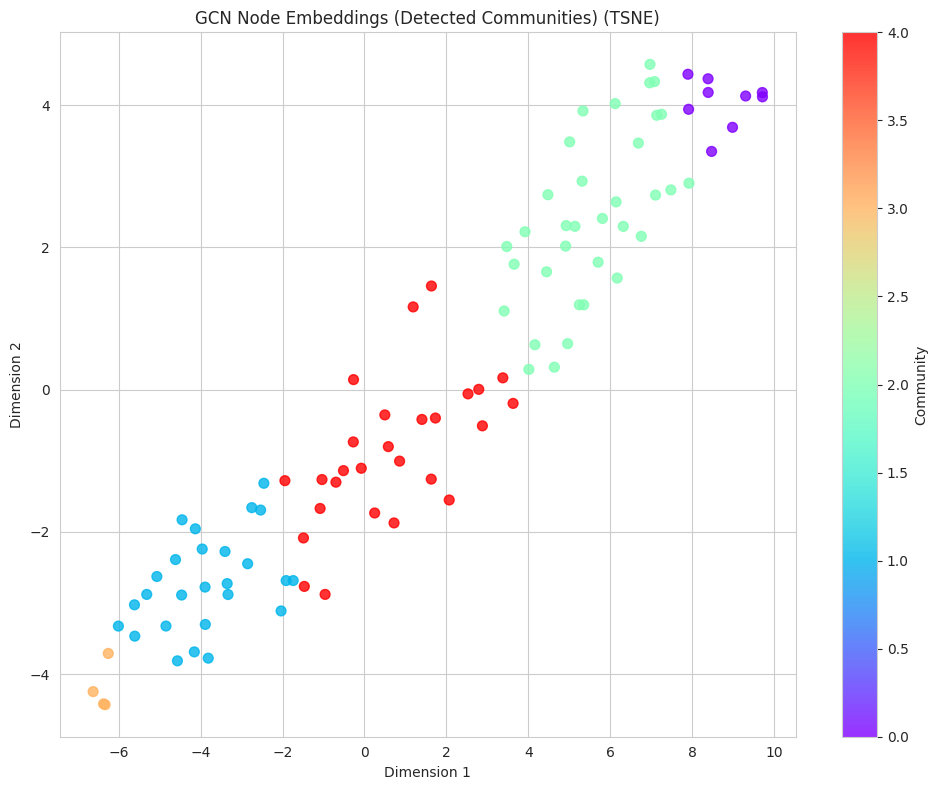


Visualizing embeddings for GRAPHSAGE...
Epoch 10/50, Loss: 1.7097
Epoch 20/50, Loss: 1.4944
Epoch 30/50, Loss: 1.3534
Epoch 40/50, Loss: 1.1243
Epoch 50/50, Loss: 0.9656


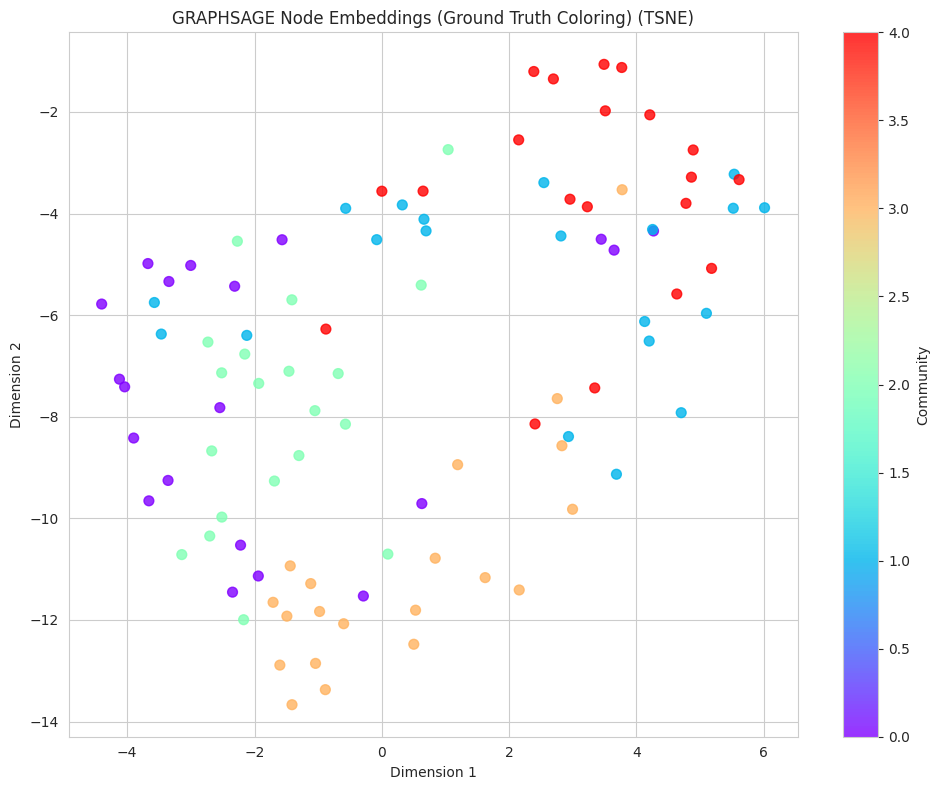

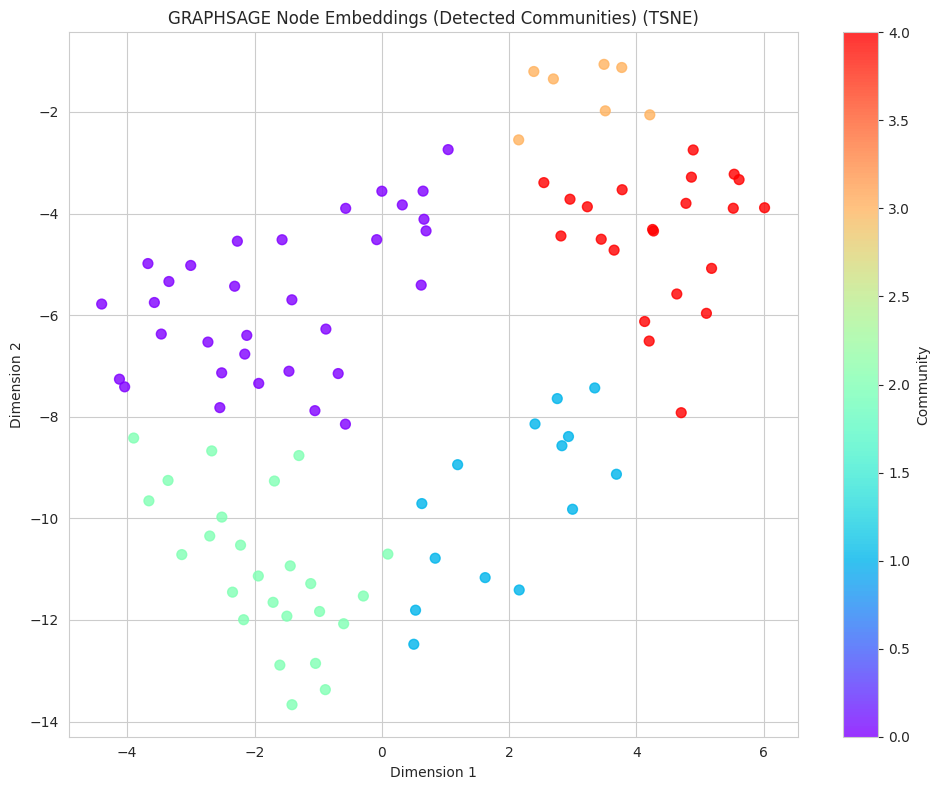


Visualizing embeddings for GAT...
Epoch 10/50, Loss: 1.5819
Epoch 20/50, Loss: 1.4317
Epoch 30/50, Loss: 1.1046
Epoch 40/50, Loss: 0.7725
Epoch 50/50, Loss: 0.4426


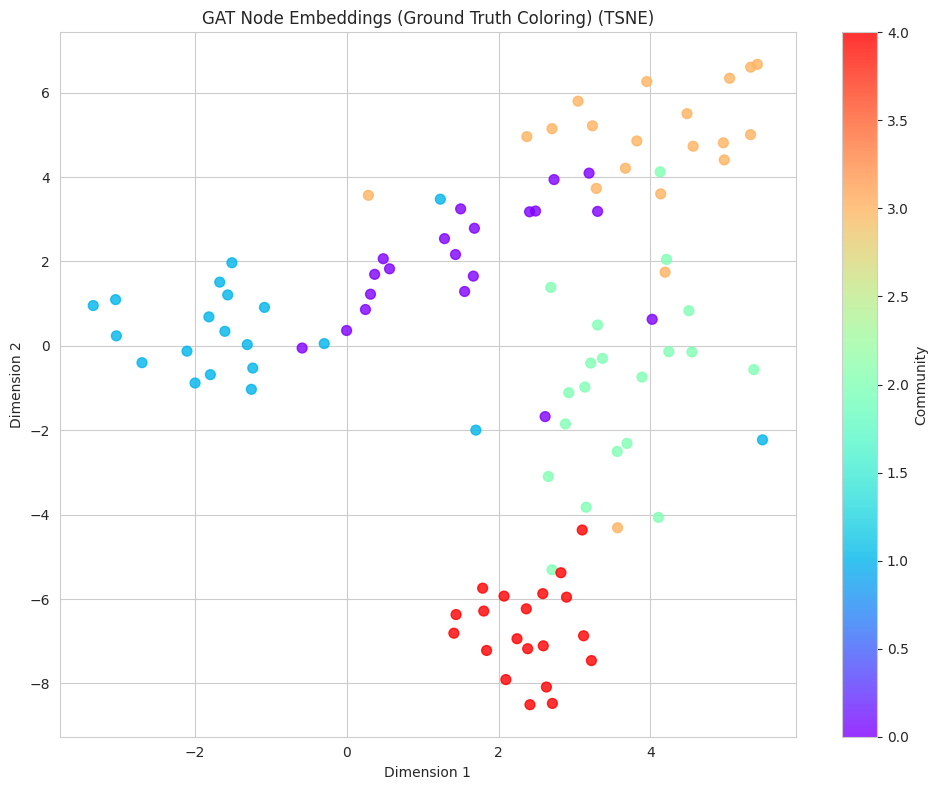

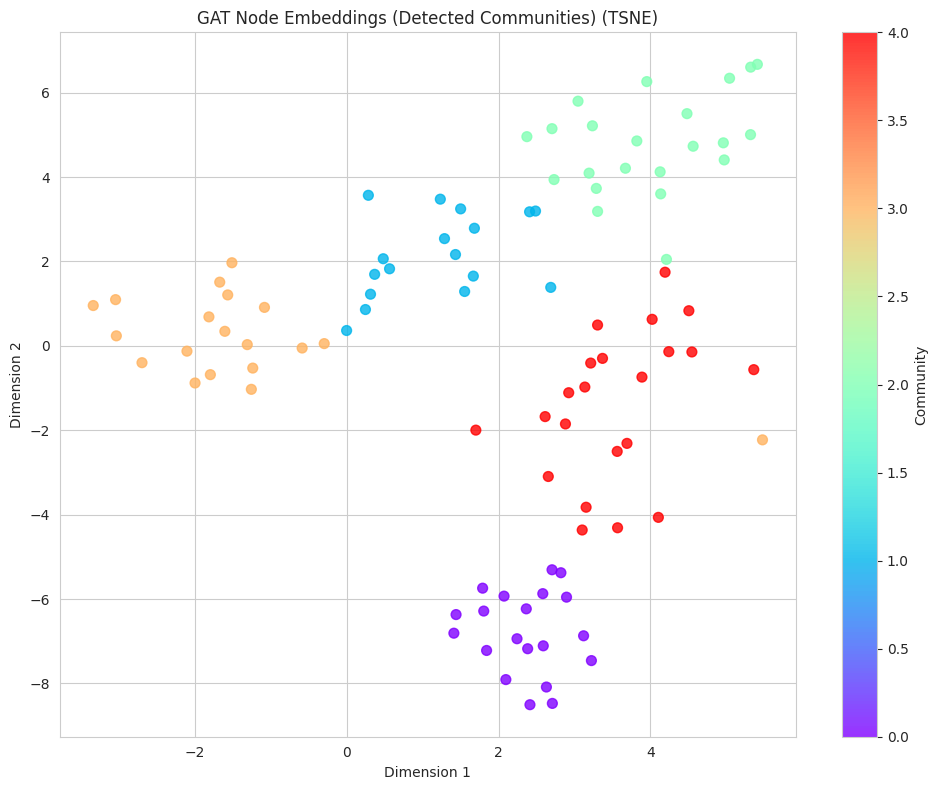


Visualizing embeddings for VGAE...
Epoch 10/50, Loss: 1.1677
Epoch 20/50, Loss: 0.8534
Epoch 30/50, Loss: 0.8697
Epoch 40/50, Loss: 0.8445
Epoch 50/50, Loss: 0.8306


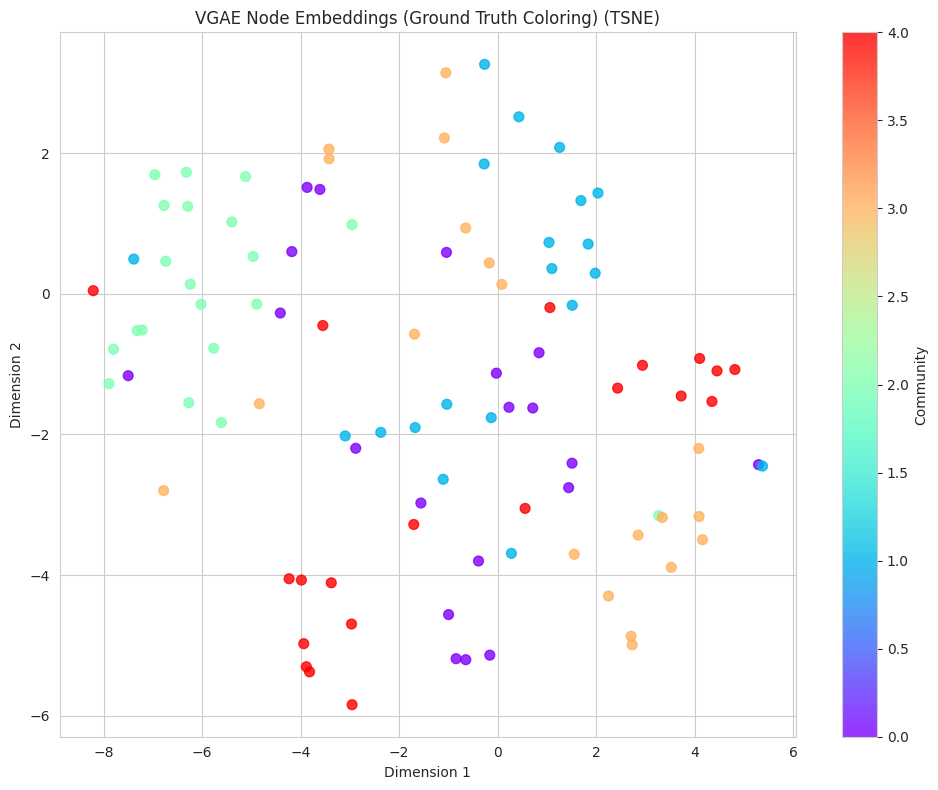

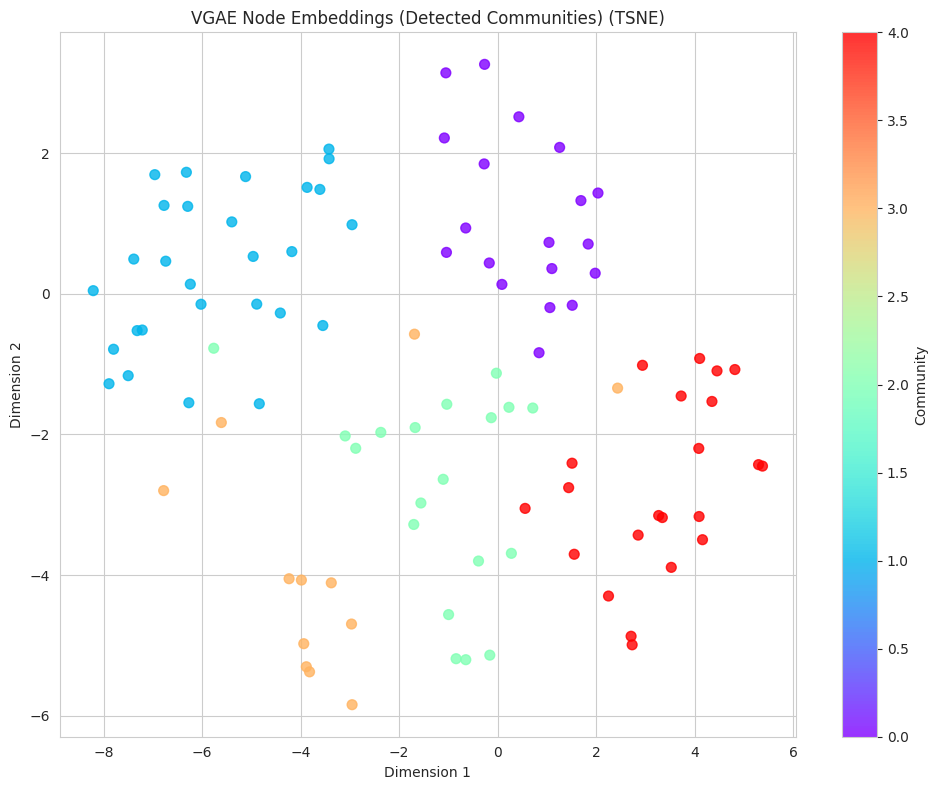

In [9]:
if TORCH_GEOMETRIC_AVAILABLE:
    # Create a custom function to extract and visualize embeddings from each model
    def visualize_model_embeddings(G, model_type, embedding_dim=16, epochs=100):
        # Convert graph to PyG format
        data = rwx_to_pyg(G)
        
        # Initialize model
        if model_type == 'gcn':
            model = GCN(data.x.size(1), hidden_dim=32, output_dim=embedding_dim)
        elif model_type == 'graphsage':
            model = GraphSAGE(data.x.size(1), hidden_dim=32, output_dim=embedding_dim)
        elif model_type == 'gat':
            model = GAT(data.x.size(1), hidden_dim=32, output_dim=embedding_dim)
        elif model_type == 'vgae':
            model = VGAE(data.x.size(1), hidden_dim=32, latent_dim=embedding_dim)
        else:
            raise ValueError(f"Unsupported model type: {model_type}")
        
        # Train model
        model = train_gnn_embedding(model, data, epochs=epochs, verbose=True)
        
        # Extract embeddings
        embeddings = extract_embeddings(model, data)
        
        # Get ground truth communities
        ground_truth = []
        for i in range(len(G)):
            node_data = G.get_node_data(i)
            if node_data and 'community' in node_data:
                ground_truth.append(node_data['community'])
            else:
                ground_truth.append(0)
        
        ground_truth = torch.tensor(ground_truth)
        
        # Visualize embeddings colored by ground truth
        plot_embeddings(embeddings, ground_truth, method='tsne', 
                      title=f"{model_type.upper()} Node Embeddings (Ground Truth Coloring)")
        
        # Detect communities from embeddings
        n_clusters = len(set(ground_truth.tolist()))
        communities = detect_communities_from_embeddings(embeddings, n_clusters=n_clusters)
        
        # Visualize embeddings colored by detected communities
        plot_embeddings(embeddings, communities, method='tsne',
                      title=f"{model_type.upper()} Node Embeddings (Detected Communities)")
        
        return embeddings, communities
    
    # Visualize embeddings for each model type
    model_types = ['gcn', 'graphsage', 'gat', 'vgae']
    
    for model_type in model_types:
        print(f"\nVisualizing embeddings for {model_type.upper()}...")
        try:
            visualize_model_embeddings(G, model_type, embedding_dim=16, epochs=50)
        except Exception as e:
            print(f"Error visualizing embeddings for {model_type}: {e}")

## 9. Summary and Conclusions

In this notebook, we have:

1. Applied various GNN-based community detection methods to our test graph
   - Graph Convolutional Network (GCN)
   - GraphSAGE
   - Graph Attention Network (GAT)
   - Variational Graph Autoencoder (VGAE)
2. Trained the models and extracted node embeddings
3. Detected communities from the embeddings
4. Evaluated the results against ground truth
5. Compared different GNN architectures
6. Visualized the node embeddings

Graph Neural Networks provide a powerful approach to community detection by learning meaningful node representations that capture both structural and attribute information. These embeddings can then be used with standard clustering algorithms to detect communities.

In the next notebook, we'll explore methods for detecting communities in dynamic graphs that evolve over time.